In [20]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from collections import deque
import matplotlib.pyplot as plt

In [2]:
def load_data():
    df = pd.read_csv("data/btc_usd_charts.csv", sep=";")
    return df

In [3]:
def transform_data(df):
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df.sort_values(by=["open_time"], ascending="True", inplace=True)
    df.set_index("open_time", inplace=True)
    df = df.resample("D")
    df = df.last()
    return df

In [4]:
df = load_data()
df = transform_data(df)

In [5]:
df.tail()

,open
open_time,
2021-03-03,50532.0
2021-03-04,48526.5
2021-03-05,48887.6
2021-03-06,48908.2
2021-03-07,50490.0


In [6]:
df.describe()

,open
count,1299.000000
mean,10213.917136
std,8227.460425
min,3206.990000
25%,6457.940000
50%,8292.860000
75%,10480.350000
max,57445.000000


## Splitting Data into a train and test set

In [7]:
def split_data(df, lookup_step=7, n_steps=7, split_size=0.2):
    result = {}
    result["df"] = df.copy()
    df["open_time"] = df.index

    # scaling the data from 0 to 1
    scaler = preprocessing.MinMaxScaler()
    df["open"] = scaler.fit_transform(np.expand_dims(df["open"].values, axis = 1))
    result["scaler"] = scaler
    
    # shifting the target column values by `lookup_step`
    df["future"] = df["open"].shift(-lookup_step)
    last_sequence = np.array(df["open"].tail(lookup_step))
    result["last_sequence"] = last_sequence
    df.dropna(inplace=True)

    # creating sequences of data
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[["open"] + ["open_time"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)

    # splitting by `split_size`
    train_samples = int((1 - split_size * len(X)))
    X_train = X[:train_samples]
    y_train = y[:train_samples]
    X_test = X[train_samples:]
    y_test = y[train_samples:]

    
    result["X_train"] = X_train
    result["y_train"] = y_train
    result["X_test"] = X_test
    result["y_test"] = y_test

    dates = result["X_test"][:, -1, -1]
    result["test_df"] = result["df"].loc[dates]
    result["X_train"] = result["X_train"][:, :, :1].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :1].astype(np.float32)
    return result

In [8]:
data = split_data(df)

## Creating the Model

In [9]:
def create_model(sequence_length, n_features=1, units=256, cell=LSTM, n_layers=2, dropout=0.4, loss="huber_loss", optimizer="adam", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


In [10]:
model = create_model(sequence_length=7, cell=LSTM)
history = model.fit(data["X_train"], data["y_train"], batch_size=64 , epochs=300 , validation_data=(data["X_test"], data["y_test"]), verbose=1)

ms/step - loss: 2.4493e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0085 - val_mean_absolute_error: 0.0797
Epoch 184/300
17/17 [==============================] - 1s 75ms/step - loss: 2.0243e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0076 - val_mean_absolute_error: 0.0745
Epoch 185/300
17/17 [==============================] - 1s 72ms/step - loss: 1.9019e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0087 - val_mean_absolute_error: 0.0825
Epoch 186/300
17/17 [==============================] - 1s 77ms/step - loss: 2.4648e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0065 - val_mean_absolute_error: 0.0659
Epoch 187/300
17/17 [==============================] - 1s 72ms/step - loss: 2.6414e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0081 - val_mean_absolute_error: 0.0766
Epoch 188/300
17/17 [==============================] - 1s 72ms/step - loss: 2.2569e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0092 - val_mean_absolute_error: 0.0836
Epoch 189/300
17/17 [===================

## Model Evaluation

In [11]:
def evaluation(model, data):
    loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
    y_pred = model.predict(data["X_test"])
    y_test = np.squeeze(data["scaler"].inverse_transform(np.expand_dims(data["y_test"], axis=0)))
    y_pred = np.squeeze(data["scaler"].inverse_transform(y_pred))
    test_df = data["test_df"]
    test_df["predictions"] = y_pred
    test_df["y_test"] = y_test
    return test_df, loss, mae

In [12]:
final_df, loss, mae = evaluation(model, data)

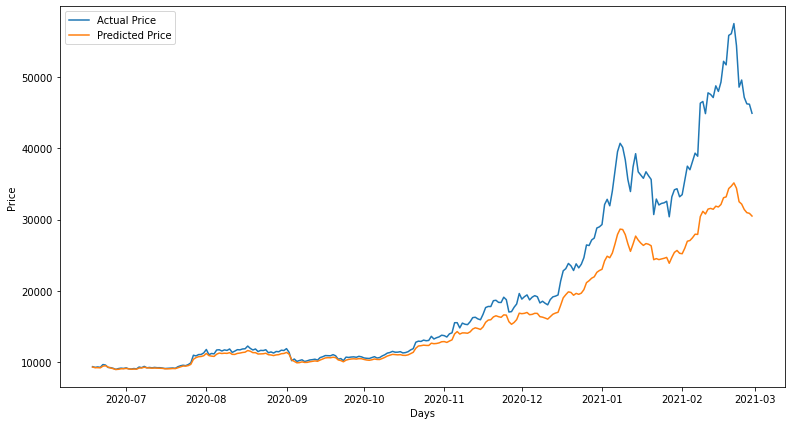

In [28]:
plt.figure(figsize=(13,7))
plt.plot(final_df["open"])
plt.plot(final_df["predictions"])
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(["Actual Price", "Predicted Price"])
plt.show()

In [30]:
print("Loss: {} \nMean Absolute Error: {}".format(loss, mae))

Loss: 0.010229192674160004 
Mean Absolute Error: 0.08650518953800201


In [49]:
import datetime
ts_now = int(datetime.datetime.now().timestamp())
model_file = "results/lstm_btc_prediction_" + str(ts_now) + ".h5" 
model.save(model_file)

results/lstm_btc_prediction_1615409882.h5
